# CIFAR-10 for Image Recoginition.

## Introduction.

In the present notebook we present an application of the Convolutional Neural Network architecture to the dataset CIFAR-10, which consists in a series of images named with 10 different labels. The main objective of this notebook is to extend the instances of the dataset changing the images and train the neural network comparing Batch normalization. 

To begin, we need to install the following libraries:

In [25]:
!pip install tensorflow-gpu==2.0.0-rc0

In [26]:
!pip install mlxtend==0.17.0

In [27]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
import numpy as np
import time
from datetime import timedelta
import math
import os

In [28]:
print(tf.__version__)

2.0.0-rc0


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Load Data.

In [30]:
from tensorflow.keras.datasets import cifar10

In [31]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [32]:
class_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

We proceed to the normalization of the training and test sets.

In [33]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

## Data Dimesions.

The data dimensions are used in several places in the source code below.

In [34]:
img_size = (32, 32)
num_channels = 3
num_classes = 10

The images are $32\times 32$ pixels, but we will crop the images to $24\times 24$ pixels.

In [35]:
img_size_cropped = 24

## Helper-function for plotting images

Function used to plot $9$ images in a $3\times 3$ grid, and writing the true and predicted classes below each image.

In [36]:
def plot_images(images, cls_true, cls_pred = None, smooth = True):
  """
  images can work as X_train[0:9, :]
  """
  assert len(images) == len(cls_true) == 9 # it raises an AssertionError if we introduce a number different to the nine entries

  # Create figure with sub-plots.
  fig, axes = plt.subplots(3, 3)

  # Adjust vertical spacing if we need to print ensemble and best-net.
  if cls_pred is None:
    hspace = 0.3
  else:
    hspace = 0.6
  fig.subplots_adjust(hspace = hspace, wspace = 0.3)

  for i, ax in enumerate(axes.flat): # axes.flat is called with the aim to iterate along all subplots
    # Interpolation type.
    if smooth:
      interpolation = 'spline16'
    else:
      interpolation = 'nearest'

    # Plot image.
    ax.imshow(images[i, :, :, :],
              interpolation = interpolation)
  
    # Name of the true class.
    cls_true_name = class_names[cls_true[i]]

    # Show true and predicted classes.
    if cls_pred is None:
      xlabel = 'True: {0}'.format(cls_true_name)
    else:
      # Name of the predicted class.
      cls_pred_name = class_names[cls_pred[i]]

      xlabel = 'True: {0}\nPred: {1}'.format(cls_true_name, cls_pred_name)

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])

  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell.
  plt.show()

### Plot a few images to see if data is correct

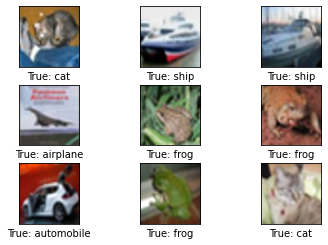

In [37]:
# Get the first images from the test-set.
images = X_test[0:9]

#Get the true classes for those images.
cls_true = y_test[0:9].flatten()

# Plot the images and labels using our helper-function above.
plot_images(images = images, cls_true = cls_true, smooth = True)

## Helper-function for creating pre-processing

In [38]:
def pre_process_image(image, training):
  # This function takes a single image as input,
  # and a boolenan whether to build the training or testing graph.

  if training:
    # For training, add the following to the Tensorflow graph.

    # Randomly crop the input image.
    image = tf.image.random_crop(image, size = [img_size_cropped, img_size_cropped, num_channels])

    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly adjust hue, contrast and saturation
    image = tf.image.random_hue(image, max_delta = 0.05)
    image = tf.image.random_contrast(image, lower = 0.3, upper = 1.0)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.image.random_saturation(image, lower = 0.0, upper = 2.0)

    # Some of these functions may overflow and result in pixel
    # values beyond the [0, 1] range. It is unclear from the
    # documentation of Tensorflow 0.10.0rc0 whether this is
    # intended. A simple solution is to limit the range.

    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.math.minimum(image, 1.0)
    image = tf.math.maximum(image, 0.0)

  else: 
    # For training, add the following to the Tensorflow graph.

    # Crop the input image around the centre so it is the same
    # size as images that are randomly cropped during training.
    image = tf.image.resize_image_with_crop_or_pad(image,
                                                   target_height = img_size_cropped,
                                                   target_width = img_size_cropped)
    
  return image


In [39]:
def pre_process(images, training):
  # Use Tensorflow to loop over all the input images and call
  # the function above which takes a simple image as input.
  images = tf.map_fn(lambda image: pre_process_image(image, training), images)

  return images

In [40]:
distorted_images = pre_process(X_train, training = True)

## Helper-function to get a random training-batch 

In [41]:
train_batch_size = 64

Function for selecting a random batch if images from the training-set.

In [42]:
def random_batch():
  # Number of images in the training-set.
  num_images = len(X_train)

  # Create a random index.
  idx = np.random.choice(num_images,
                         size = train_batch_size,
                         replace = False)
  
  # Use the random index to select random images and labels.
  x_batch = X_train[idx, :, :, :]
  y_batch = y_train[idx, :]

  return x_batch, y_batch

## Helper-function to plot example errors

In [43]:
def plot_example_errors(cls_pred, correct):
  # This function is called from print_test_accuracy() below

  # cls_pred is an array of the predicted class-number for
  # all images in the test-set.

  # correct is a boolean array whether the predicted class 
  # is equal to the true class for each image in the test-set.

  # Negate the boolean array.
  incorrect = (correct == False)

  # Get the images from the test-set that have been 
  # incorrectly classified.
  images = X_test[incorrect]

  # Get the predicted classes for those images
  cls_pred = cls_pred[incorrect]

  # Get the true classes for those images
  cls_true = y_test[incorrect]

  # Plot the first 9 images.
  plot_images(images = images[0:9],
             cls_true = cls_true[0:9],
             cls_pred = cls_pred[0:9])

## Helper - functions for calculating classifications

In [44]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
  # Number of images.
  num_images = len(images)

  # Allocate an array for the predicted classes which
  # will be calculated in batches and filled into this array.
  cls_pred = np.zeros(shape = num_images, dtype = np.int)

  # Now calculate the predicted classes for the batches.
  # We will just iterate through all the batches.
  # There might be a more clever and Pythonic way of doing this.

  # The starting index for the next batch is denoted i.
  i = 0

  while i < num_images:
    # The ending index for the next batch is denoted j.
    j = min(i + batch_size, num_images)

    # Create a feed-dict with the images and labels 
    # between index i and j.
    feed_dict = {x : images[i:j, :],
                 y_true : labels[i:j, :]}

    # Calculate the predicted class 

## Build Convolutional Neural Network Model

In [48]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = [32, 32, 3]))
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu')) # we don't have to define the input size here
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'valid'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 10, activation = 'softmax'))
model.add(BatchNormalization())

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [50]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

In [51]:
history = model.fit(X_train, y_train, batch_size = 10, epochs = 10, verbose = 1, validation_data = (X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50000/50000 [==============================] - 311s 6ms/sample - loss: 6.6547 - sparse_categorical_accuracy: 0.1367 - val_loss: 3.2995 - val_sparse_categorical_accuracy: 0.1695
Epoch 2/10
50000/50000 [==============================] - 315s 6ms/sample - loss: 2.2092 - sparse_categorical_accuracy: 0.2336 - val_loss: 2.2681 - val_sparse_categorical_accuracy: 0.1937
Epoch 3/10
50000/50000 [==============================] - 314s 6ms/sample - loss: 1.9425 - sparse_categorical_accuracy: 0.3463 - val_loss: 1.7766 - val_sparse_categorical_accuracy: 0.4183
Epoch 4/10
50000/50000 [==============================] - 314s 6ms/sample - loss: 1.8531 - sparse_categorical_accuracy: 0.3816 - val_loss: 1.7695 - val_sparse_categorical_accuracy: 0.4350
Epoch 5/10
50000/50000 [==============================] - 314s 6ms/sample - loss: 1.8508 - sparse_catego

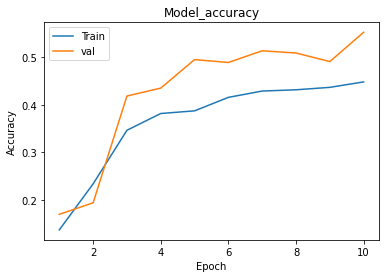

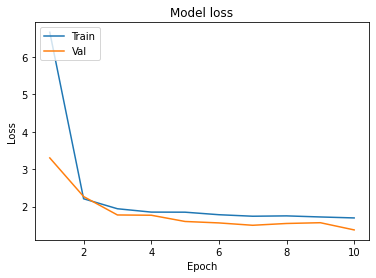

In [52]:
# plot training and validation accuracy values
epoch_range = range(1, 11)
plt.plot(epoch_range, history.history['sparse_categorical_accuracy'])
plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc = 'upper left')
plt.show()

# plot training and validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

In [53]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [54]:
y_pred = model.predict_classes(X_test)

In [55]:
mat = confusion_matrix(y_test, y_pred)

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7790893048>)

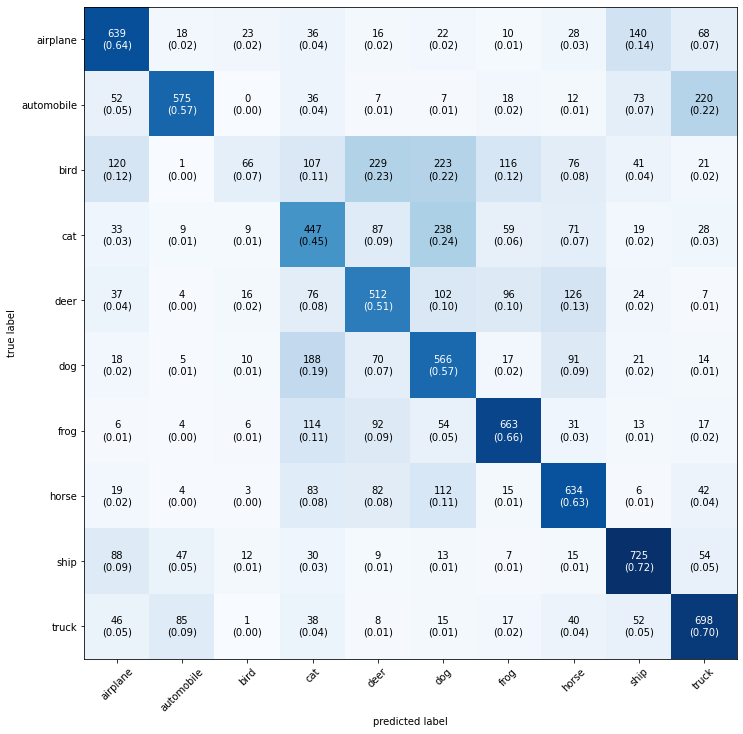

In [58]:
plot_confusion_matrix(mat, figsize = (12, 12), class_names = class_names, show_normed = True)